In [1]:
# standard python utilities
import os
import sys
import glob
import pandas as pd
import numpy as np
import calendar
import time

# standard python plotting utilities
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# standard geospatial python utilities
import pyproj # for converting proj4string
import shapely
import geopandas as gpd
# import rasterio

# mapping utilities
# import contextily as ctx
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm
from matplotlib.ticker import MaxNLocator

import flopy
import flopy.utils.binaryfile as bf


In [18]:
from os.path import dirname, basename
doc_dir = os.getcwd()
while basename(doc_dir) != 'Documents':
    doc_dir =  dirname(doc_dir)
# dir of all gwfm data
gwfm_dir = dirname(doc_dir)+'/Box/research_cosumnes/GWFlowModel'

py_dir = doc_dir +'/GitHub/CosumnesRiverRecharge/python_utilities/'
## Set up directory referencing
# Package data
bas_dir = gwfm_dir + 'BAS6/'
proj_dir = gwfm_dir+'/Levee_setback/'
plt_dir = proj_dir+'figures/'


In [3]:
from importlib import reload

map_fxn_dir = doc_dir+'/GitHub/CosumnesRiverRecharge/python_utilities'
if map_fxn_dir not in sys.path:
    sys.path.append(map_fxn_dir)
# sys.path
from map_obs_plt import plt_bc_hk, plot_head_simple, plot_dtw_simple
from map_cln import gdf_2_lims

# from importlib import reload
# # importlib.reload
# reload(tc)

In [4]:
# run_dir = 'C://WRDAPP/GWFlowModel'
run_dir = 'F://WRDAPP/GWFlowModel'
loadpth = run_dir +'/Cosumnes/levee_setback/streamflow/'

# runs = os.listdir(loadpth)
# runs
runs = ['setback_streamflow','historical_streamflow']


In [5]:
# model_ws =loadpth+'/actual_200cfs'

# i=0
# os.listdir(loadpth+runs[i])
# glob.glob(loadpth+runs[i]+'/*.nam')[0]
# model_ws = loadpth+runs[i]

# model_nam = 'setback_streamflow'
model_nam = 'historical_streamflow'


model_ws = loadpth+model_nam


In [6]:

m = flopy.modflow.Modflow.load('MF.nam', model_ws= model_ws, 
                                exe_name='mf-owhm', version='mfnwt')

# m_ss = flopy.modflow.Modflow.load('MF.nam', model_ws= loadpth+'historical_SS', 
#                                 exe_name='mf2005', version='mfnwt')

In [19]:
sfr_dir = gwfm_dir+'/SFR_data/'
grid_sfr = gpd.read_file(sfr_dir+'/final_grid_sfr/grid_sfr.shp')
m_domain = gpd.read_file(gwfm_dir+'/DIS_data/NewModelDomain/GWModelDomain_52_9deg_UTM10N_WGS84.shp')
grid_p = gpd.read_file(gwfm_dir+'/DIS_data/grid/grid.shp')
lak_grid_clip = gpd.read_file(proj_dir+'lak_grid_clip/lak_grid_clip.shp')


In [20]:
hdobj = flopy.utils.HeadFile(model_ws+'/MF.hds')
spd_stp = hdobj.get_kstpkper()
times = hdobj.get_times()
cbc = model_ws+'/MF.cbc'

strt_date = pd.to_datetime(m.dis.start_datetime)
dates = strt_date+(np.asarray(times)-1).astype('timedelta64[D]')

dt_ref = pd.DataFrame(dates, columns=['dt'])
dt_ref['kstpkper'] = spd_stp


# Check oscillating cells

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\plotting.py:71: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if mpl >= LooseVersion("3.4") or (mpl > LooseVersion("3.3.2") and "+" in mpl):
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\setuptools\_distutils\version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


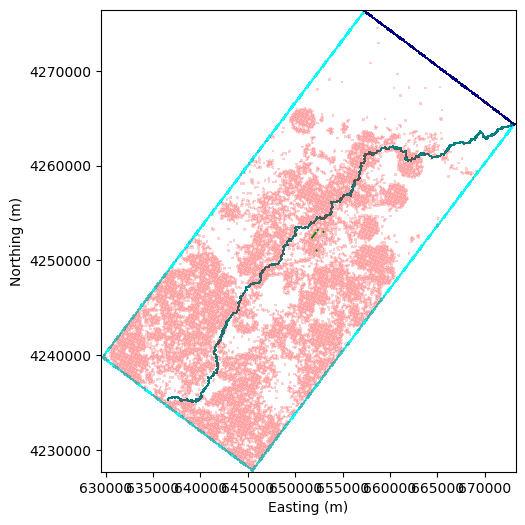

In [8]:
# grid_p.plot()
fig,ax=plt.subplots(figsize=(6,6))
ax.set_aspect(1)
plt_bc_hk(model=m,ax=ax)

rc_oscillate = [(54,124),(51,121),(51,123),(51,120),(51,119),(51,118),(57,114)]
oscillate_gpd = grid_p.set_index(['row','column']).loc[rc_oscillate,:]
oscillate_gpd.plot(ax=ax, color='green')

oscillate_gpd.geometry = oscillate_gpd.buffer(1000)
osc_sfr = gpd.sjoin(grid_sfr,oscillate_gpd,how='inner')
# osc_sfr = osc_sfr.dissolve('node_left')
# osc_sfr

In [9]:
np.quantile(m.sfr.reach_data.strhc1,[0,0.5,0.75,1])

array([0.00562464, 0.01824047, 0.05290898, 1.        ])

In [10]:
osc_sfr.reach.values

array([136, 137, 138, 139, 140, 141, 142, 138, 139, 140, 141, 142, 143,
       140, 141, 142, 143, 141, 142, 143, 142], dtype=int64)

In [11]:
m.sfr.reach_data.strhc1[osc_sfr.reach.values]

array([0.01665106, 0.2750453 , 0.00832547, 0.00562464, 0.00562464,
       0.00562464, 0.00562464, 0.00832547, 0.00562464, 0.00562464,
       0.00562464, 0.00562464, 0.00562464, 0.00562464, 0.00562464,
       0.00562464, 0.00562464, 0.00562464, 0.00562464, 0.00562464,
       0.00562464], dtype=float32)

In [12]:
# shapefile rectangle of the area surrounding the Dam within about 5 cells
zon_dam_gpd = gpd.read_file(gwfm_dir+'/Blodgett_Dam/geospatial/zon_bud_extent/zon_bud_extent.shp')
grid_p = gpd.read_file(gwfm_dir+'/DIS_data/grid/grid.shp')

zon_cells = gpd.sjoin(grid_p,zon_dam_gpd,how='right',op='within')
# zon_cells = gpd.sjoin(grid_p,zon_dam_gpd) #includes more cells, including with high conductance

# filter zone budget for Blodgett Dam to just within 5 cells or so of the Dam
# zon_dam = np.zeros((m.dis.nrow,m.dis.ncol),dtype=int)
zon_dam = np.zeros((grid_p.row.max(),grid_p.column.max()),dtype=int)

zon_dam[zon_cells.row-1,zon_cells.column-1]=1

zon_mod = np.ones((grid_p.row.max(),grid_p.column.max()),dtype=int)

In [13]:
# idx can be (layer, row, column)

zon_allk = np.repeat(np.arange(0,m.dis.nlay),len(zon_cells))
zon_alli = np.tile((zon_cells.row-1).values,m.dis.nlay)
zon_allj = np.tile((zon_cells.column-1).values,m.dis.nlay)
zon_allkij = list(zip(zon_allk,zon_alli,zon_allj))

dem_data = m.dis.top.array

In [24]:
dt_ref

,dt,kstpkper
0,2016-10-01,"(0, 0)"
1,2016-10-02,"(0, 1)"
2,2016-10-03,"(0, 2)"
3,2016-10-04,"(0, 3)"
4,2016-10-05,"(0, 4)"
...,...,...
1410,2020-09-27,"(0, 1457)"
1411,2020-09-28,"(0, 1458)"
1412,2020-09-29,"(0, 1459)"
1413,2020-09-30,"(0, 1460)"


In [21]:
event_dates = ['2019-01-01','2019-02-01','2019-03-01','2019-04-01','2019-05-01','2019-06-01']
post_dates = ['2019-7-01','2019-8-01','2019-9-01','2019-10-01']
event_spd = dt_ref.set_index('dt').loc[event_dates].values
post_spd = dt_ref.set_index('dt').loc[post_dates].values

KeyError: "None of [Index(['2019-01-01', '2019-02-01', '2019-03-01', '2019-04-01', '2019-05-01',\n       '2019-06-01'],\n      dtype='object', name='dt')] are in the [index]"

In [22]:
zon_hd = hdobj.get_data(kstpkper=(0,0))
zon_ts = hdobj.get_ts(idx=zon_allkij)

In [23]:
start_date = pd.to_datetime(m.dis.start_datetime)- np.ones(1).astype('timedelta64[D]')

Text(0, 0.5, 'Groundwater Elevation (m)')

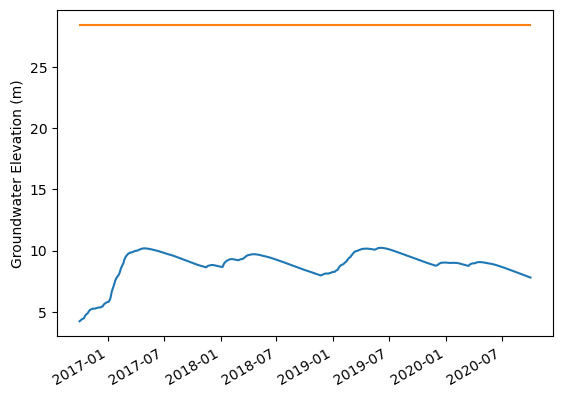

In [25]:
ts_df = pd.DataFrame(zon_ts, columns = ['totim']+zon_allkij)
ts_df = ts_df.set_index('totim')
ts_df.index =  start_date + ts_df.index.values.astype('timedelta64[D]')
ts_df.mean(axis=1).plot()

mean_dem = dem_data[(zon_cells.row-1).values,(zon_cells.column-1).values].mean()
plt.plot([ts_df.index.min(), ts_df.index.max()],[mean_dem,mean_dem], label='Mean Ground Surface Elevation')

plt.ylabel('Groundwater Elevation (m)')

In [26]:
ts_long = ts_df.melt(ignore_index=False,value_name='head_m')

ts_long = ts_long.reset_index().rename({'index':'Date'},axis=1)
ts_long['k'] = ts_long.variable.str[0].values
ts_long['i'] = ts_long.variable.str[1].values
ts_long['j'] = ts_long.variable.str[2].values
ts_long = ts_long.drop(['variable'],axis=1)
# get hk to help sort head by region
ts_long['hk'] = m.lpf.hk.array[ts_long.k,ts_long.i,ts_long.j]

n = ts_long.hk.quantile([0.76]).values
ts_long.loc[ts_long.hk.values<n,'facies'] = 'fine'
ts_long.loc[ts_long.hk.values>=n,'facies'] = 'coarse'

AttributeError: 'NoneType' object has no attribute 'hk'

In [ ]:
# ts_long.to_csv(plt_dir+'head_timeseries_'+model_nam+'.csv')
# ts_setback

In [ ]:
sfr_ij = grid_sfr.loc[:,['row','column','z']]
sfr_ij.row = (sfr_ij.row-1).astype(int)
sfr_ij.column = (sfr_ij.column-1).astype(int)
ts_long_sfr = ts_long.join(sfr_ij.set_index(['row','column']),on=['i','j'],how='inner')
ts_long_sfr.loc[ts_long_sfr.k==0]

In [ ]:
fig,ax=plt.subplots()
ts_lay_mean = ts_long.groupby(['k','Date'],as_index=False).mean()
ts_lay_mean.set_index('k').loc[0].plot(x='Date',y='head_m',ax=ax,label='Historic')

ts_lay_mean = ts_setback.groupby(['k','Date'],as_index=False).mean()
ts_lay_mean.set_index('k').loc[0].plot(x='Date',y='head_m',ax=ax,label='Setback')

In [ ]:
levels = [-60, -40,-20,-10,0,10,20,30,40,60]

fig,ax=plt.subplots(3,2,figsize=(12,12), sharex='col',sharey='row')
fig.tight_layout()
for n,plt_spd in enumerate(event_spd):
    ax_n =ax[int(n/2), n% 2]

    zon_hd = hdobj.get_data(kstpkper=plt_spd[0])
#     im = ax_n.imshow(zon_hd[0,:,:], vmin=0,vmax=40, cmap='viridis')
    mapview = flopy.plot.PlotMapView(model=m,ax=ax_n)
    contour_set = mapview.contour_array(zon_hd[0,:,:], masked_values=[-999.99], levels=levels, ax=ax_n)
#     contour_set = ax_n.contour(zon_hd[0,:,:], levels = levels,cmap='viridis')
    ax_n.set_title(event_dates[n])
hcb = plt.colorbar(contour_set, shrink = 0.5,ax=ax)
hcb.set_label('Head (m)')
ax[0,0].ticklabel_format(style='plain')

# ax.clabel(contour_set, contour_set.levels[0::2], inline=True, fontsize=8)
# fig.colorbar(im)